In [250]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# LOAD DATASET

### LOAD DATASET MANUALLY

In [251]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [252]:
def load_data(data_dir, train=True):
    
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []
    cifar_test_data = None
    cifar_test_filenames = []
    cifar_test_labels = []
    if train:
        for i in range(1,6):
            cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
            if i == 1:
                cifar_train_data = cifar_train_data_dict[b'data']
            else:
                cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))

            cifar_train_filenames += cifar_train_data_dict[b'filenames']
            cifar_train_labels += cifar_train_data_dict[b'labels']
        cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))

        cifar_train_filenames = np.array(cifar_train_filenames)
        cifar_train_labels = np.array(cifar_train_labels)
    
        return cifar_train_data, cifar_train_filenames, cifar_train_labels
    
    else:
        cifar_test_data_dict = unpickle(data_dir + "/test_batch")
        cifar_test_data = cifar_test_data_dict[b'data']
        cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))

        cifar_test_filenames = np.array(cifar_test_data_dict[b'filenames'])
        cifar_test_labels = np.array(cifar_test_data_dict[b'labels'])
        return cifar_test_data, cifar_test_filenames, cifar_test_labels
    
    

In [253]:
data_batches, filenames, labels = load_data('cifar-10-batches-py')
test_batch, test_filenames, test_labels = load_data('cifar-10-batches-py', train=False)

In [254]:
batches_meta = unpickle('cifar-10-batches-py/batches.meta')
label_names = batches_meta[b'label_names']
batches_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [255]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [256]:
tensor_cifar10 = torch.tensor(data_batches, dtype=torch.float32)
tensor_cifar10 /= 255.0
tensor_cifar10.shape

torch.Size([50000, 3, 32, 32])

In [257]:
# Add label to each tensor
tensor_cifar10 = [(tensor_cifar10[i], labels[i]) for i in range(len(tensor_cifar10))]


In [258]:
tensor_cifar10[0][0].shape

torch.Size([3, 32, 32])

this is an image of a 


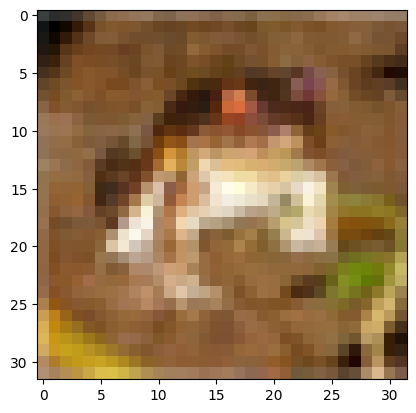

In [259]:
img, label = tensor_cifar10[0]
plt.imshow(img.permute(1, 2, 0))
print("this is an image of a ", )

In [260]:
train_ds, val_ds = random_split(tensor_cifar10, [40000, 10000])
test_ds = [(torch.tensor(test_batch[i], dtype=torch.float32), test_labels[i]) for i in range(len(test_batch))]


In [261]:
#hyperparameters
batch_size = 128

In [262]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

### LOAD DATA FROM TORCHVISION.DATASETS

In [281]:
dataset = torchvision.datasets.CIFAR10(root='data/', train=True, transform=transforms.ToTensor(), download=False)
dataset.data.shape

(50000, 32, 32, 3)

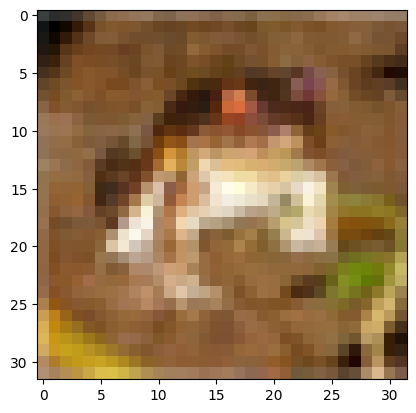

In [264]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))

# TRAIN MODEL

In [265]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [272]:
class Cifar10Model(nn.Module):
    def __init__(self, input_size=3*32*32, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)#else xb.reshape(-1, 3*32*32)
        out = self.linear(xb)
        #out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = Cifar10Model()

In [273]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [274]:
evaluate(model, val_loader)

{'val_loss': 2.3294970989227295, 'val_acc': 0.11396484076976776}

In [275]:
history = fit(100, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.1361, val_acc: 0.2406
Epoch [1], val_loss: 2.0586, val_acc: 0.3061
Epoch [2], val_loss: 2.0121, val_acc: 0.3047
Epoch [3], val_loss: 1.9788, val_acc: 0.3286
Epoch [4], val_loss: 1.9544, val_acc: 0.3364
Epoch [5], val_loss: 1.9357, val_acc: 0.3426
Epoch [6], val_loss: 1.9201, val_acc: 0.3455
Epoch [7], val_loss: 1.9083, val_acc: 0.3483
Epoch [8], val_loss: 1.8985, val_acc: 0.3530
Epoch [9], val_loss: 1.8895, val_acc: 0.3499
Epoch [10], val_loss: 1.8789, val_acc: 0.3582
Epoch [11], val_loss: 1.8721, val_acc: 0.3569
Epoch [12], val_loss: 1.8662, val_acc: 0.3585
Epoch [13], val_loss: 1.8599, val_acc: 0.3603
Epoch [14], val_loss: 1.8548, val_acc: 0.3638
Epoch [15], val_loss: 1.8498, val_acc: 0.3645
Epoch [16], val_loss: 1.8457, val_acc: 0.3646
Epoch [17], val_loss: 1.8411, val_acc: 0.3678
Epoch [18], val_loss: 1.8377, val_acc: 0.3696
Epoch [19], val_loss: 1.8338, val_acc: 0.3720
Epoch [20], val_loss: 1.8301, val_acc: 0.3724
Epoch [21], val_loss: 1.8276, val_acc: 0.371

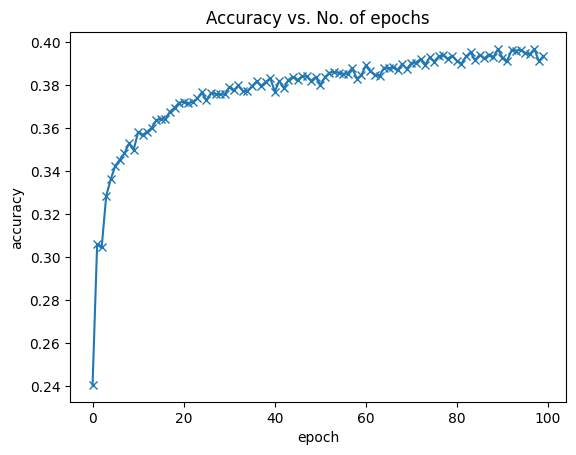

In [276]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [277]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 159.76010131835938, 'val_acc': 0.3836914002895355}